In [1]:
from torchvision import datasets, transforms, models
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
import torchvision.transforms as T
import torch

from PIL import Image
import requests

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn

from torchsummary import summary

In [2]:
from models.backbone import Backbone
from models.encoder import EncoderModule
from models.joiner import Joiner
from models.losses import Attention_penalty_factor, Generator_loss
from models.unet import UNet

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
H = 180
W=180

transform = T.Compose([
T.Resize((H,W)),
T.ToTensor(),
T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 10, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

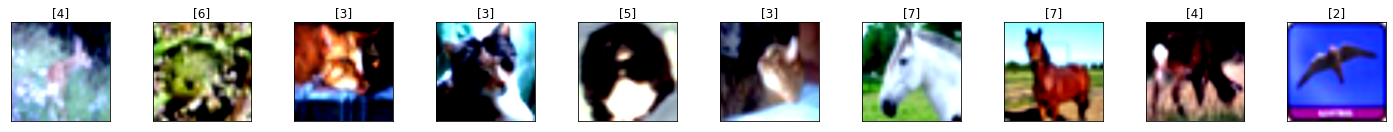

In [7]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [8]:
unet = UNet(3,3)
backbone = Backbone().to(device)
encoder = EncoderModule().to(device)
model = Joiner(backbone, encoder, hidden_dim=512, image_h=H, image_w=W)

In [9]:
generator = unet.to(device)
model = model.to(device)

In [10]:
#TESTING MODEL ON A SINGLE IMAGE

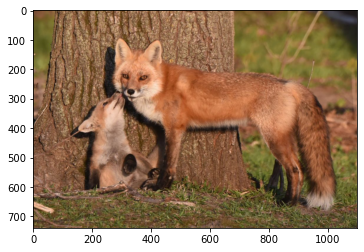

In [11]:
url = 'https://ogden_images.s3.amazonaws.com/www.timesrepublican.com/images/2019/05/02231710/Fox-WEB-1100x739.jpg'

im = Image.open(requests.get(url, stream=True).raw)
plt.plot()
plt.imshow(im)

In [12]:
img = transform(im).unsqueeze(0)
print("Input shape:", img.shape)

Input shape: torch.Size([1, 3, 180, 180])


In [13]:
outputs, pattn = model(img.to(device))

In [14]:
print("Output shape:", outputs.shape)
#print("Feature Map shape:", f_map.shape)
#print("Attention Maps shape:", sattn.shape)
#print("Encoder output shape:", att.shape)
#print("Positional Encoding shape:", pos.shape)

Output shape: torch.Size([1, 10])


In [15]:
summary(generator, input_size=(3, 180, 180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 180, 180]           1,792
       BatchNorm2d-2         [-1, 64, 180, 180]             128
              ReLU-3         [-1, 64, 180, 180]               0
            Conv2d-4         [-1, 64, 180, 180]          36,928
       BatchNorm2d-5         [-1, 64, 180, 180]             128
              ReLU-6         [-1, 64, 180, 180]               0
        DoubleConv-7         [-1, 64, 180, 180]               0
         MaxPool2d-8           [-1, 64, 90, 90]               0
            Conv2d-9          [-1, 128, 90, 90]          73,856
      BatchNorm2d-10          [-1, 128, 90, 90]             256
             ReLU-11          [-1, 128, 90, 90]               0
           Conv2d-12          [-1, 128, 90, 90]         147,584
      BatchNorm2d-13          [-1, 128, 90, 90]             256
             ReLU-14          [-1, 128,

In [16]:
#summary(model, input_size=(3, 180, 180))

In [17]:
out = generator(img.to(device))

In [18]:
out.shape

torch.Size([1, 3, 180, 180])

In [19]:
#for inputs, labels in training_loader:
#    print(inputs.requires_grad)

In [20]:
#Training Model

In [21]:
model_criterion = nn.CrossEntropyLoss()
gen_criterion = Generator_loss()
model_optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr = 0.0001)

In [22]:
def train_model(inputs, labels, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    
    real_inputs = inputs.to(device) # allow gpu use
    labels = labels.to(device) # allow gpu use
    # Pass real images through discriminator
    real_preds, pattn = model(real_inputs)
    #real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = model_criterion(real_preds, labels)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    noised_inputs = generator(real_inputs)

    # Pass fake images through discriminator
    noised_preds, noised_pattn = model(noised_inputs)
    noised_loss = model_criterion(noised_preds, labels)
    noised_score = torch.mean(noised_preds).item()

    # Update discriminator weights
    loss = real_loss + noised_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, noised_score

In [29]:
def train_generator(inputs, labels, opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    real_inputs = inputs.to(device) # allow gpu use
    labels = labels.to(device) # allow gpu use
    
    # Generate fake images
    noised_inputs = generator(real_inputs)
    
    # Try to fool the discriminator
    preds, pattn = model(noised_inputs)
    model_loss = model_criterion(preds, labels)
    loss = gen_criterion(pattn, noised_inputs, real_inputs, model_loss)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [30]:
def fit(epochs, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    noise_scores = []
    
    for epoch in range(epochs):
        
        for inputs, labels in training_loader:
            # Train discriminator
            loss_d, real_score, noise_score = train_model(inputs, labels, model_optimizer)
            # Train generator
            loss_g = train_generator(inputs, labels, gen_optimizer)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        noise_scores.append(noise_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, noise_score))
    
        # Save generated images
        #save_samples(epoch+start_idx, fixed_latent, show=False)

    
    return losses_g, losses_d, real_scores, noise_scores

In [31]:
history = fit(epochs = 2)

Epoch [1/2], loss_g: 544.8573, loss_d: 4.1469, real_score: 0.2161, fake_score: 0.2165
Epoch [2/2], loss_g: 509.3082, loss_d: 2.6153, real_score: 0.0313, fake_score: 0.0305


In [ ]:
epochs = 2
running_loss_history = [] # training loss - to generate a plot
running_corrects_history = [] # traning accuracy
val_running_loss_history = [] # validation loss
val_running_corrects_history = [] # validation accuracy

for e in range(epochs):
  
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    for inputs, labels in training_loader:
    #TRAINING
        inputs = inputs.to(device) # allow gpu use
        labels = labels.to(device) # allow gpu use
        outputs = unet(inputs) #gives the output of the last layer
        x, att, sattn, f_map, pos, pattn = model(outputs)
        loss = criterion(pattn, outputs, inputs) # comparing outputs and labels using the criteria

        optimizer.zero_grad() #zero the grad
        loss.backward() #backpropagation
        optimizer.step() #optimize weights 

        #_, preds = torch.max(outputs, 1) # return the index of the maximum value predicted for that image (used to generate the accuracy)
        running_loss += loss.item() # the sum of the loss of all itens
        #running_corrects += torch.sum(preds == labels.data) # the sum of correct prediction on an epochs

    else:
        #VALIDATION
        with torch.no_grad(): # to save memory (temporalely set all the requires grad to be false)
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device) # allow gpu use
                val_labels = val_labels.to(device) # allow gpu use
                val_outputs = unet(val_inputs) #passes the image through the network and get the output
                val_x, att, sattn, f_map, pos, val_pattn = model(val_outputs)
                val_loss = criterion(val_pattn, val_outputs, inputs) #compare output and labels to get the loss 

                #_, val_preds = torch.max(val_outputs, 1) #same as for training
                val_running_loss += val_loss.item() #same as for training
                #val_running_corrects += torch.sum(val_preds == val_labels.data) #same as for training

    #TRAINING LOSS AND ACCURACY
    epoch_loss = running_loss/len(training_dataset) # the sum of the loss of all itens divided by the number of itens
    #epoch_acc = running_corrects.float()/ len(training_dataset) # the sum of correct predictions divided by the number of itens
    running_loss_history.append(epoch_loss) #append to respective list
    #running_corrects_history.append(epoch_acc) #append to respective list

    #VALIDATION LOSS AND ACCURACY
    val_epoch_loss = val_running_loss/len(validation_dataset)
    #val_epoch_acc = val_running_corrects.float()/ len(validation_dataset)
    val_running_loss_history.append(val_epoch_loss) #append to respective list
    #val_running_corrects_history.append(val_epoch_acc) #append to respective list
    print('epoch :', (e+1))
    print('training loss: {:.4f} '.format(epoch_loss))
    print('validation loss: {:.4f}'.format(val_epoch_loss))

In [32]:
out2 = generator(img.to(device))

In [34]:
#out == out2

In [ ]:
for param in unet.parameters():
    print(param.requires_grad, param.grad.data.sum())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


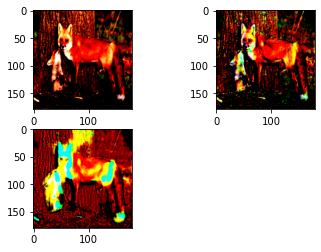

In [35]:
plt.subplot(221)
plt.imshow(img[0].cpu().permute(1, 2, 0))
plt.subplot(222)
plt.imshow(out[0].cpu().detach().permute(1, 2, 0))
plt.subplot(223)
plt.imshow(out2[0].cpu().detach().permute(1, 2, 0))